In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/'

Mounted at /content/drive


# Specifying each path

In [3]:
dataset = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/model/point_history_classifier/point_history.csv'
model_save_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/model/point_history_classifier/point_history_classifier.hdf5'

# Number of classes

In [4]:
NUM_CLASSES = 4

# Input length

In [5]:
TIME_STEPS = 16
DIMENSION = 2

# Load learning data

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [9]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 1086 (4.24 KB)
Trainable params: 1086 (4.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early termination
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
29/32 [==========================>...] - ETA: 0s - loss: 1.3655 - accuracy: 0.4558 
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/model/point_history_classifier/point_history_classifier.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 2s 25ms/step - loss: 1.3638 - accuracy: 0.4582 - val_loss: 1.3531 - val_accuracy: 0.5227
Epoch 2/1000
19/32 [================>.............] - ETA: 0s - loss: 1.3478 - accuracy: 0.5070
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 6ms/step - loss: 1.3423 - accuracy: 0.5018 - val_loss: 1.3276 - val_accuracy: 0.5536
Epoch 3/1000
20/32 [=================>............] - ETA: 0s - loss: 1.3186 - accuracy: 0.5203
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Computer Vision/model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 8ms/step - loss: 1.3160 - accuracy: 0.5204 - val_loss: 1.2971 - val_accuracy: 0.5642
Epoch 4/1000
19/32 [================>.............] - ETA: 0s - loss: 1.2917 - accuracy: 0.5415
Epoch 4: saving model to /content/drive/My

In [14]:
# Loading a saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Reasoning test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 98ms/step
[0.91364056 0.02562974 0.04011054 0.02061918]
0


# Confusion matrix

42/42 [==============================] - 0s 1ms/step


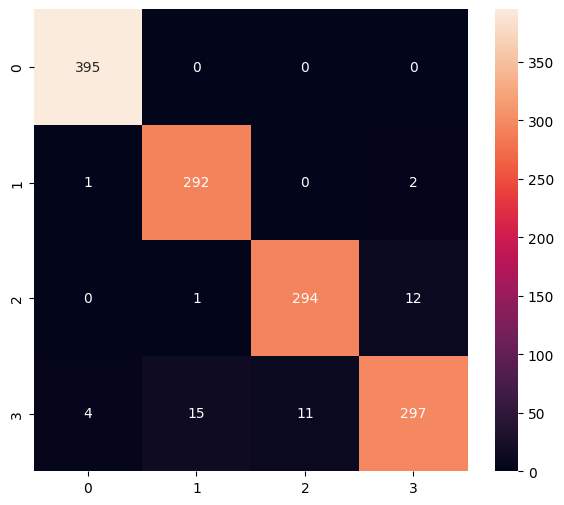

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.95      0.99      0.97       295
           2       0.96      0.96      0.96       307
           3       0.95      0.91      0.93       327

    accuracy                           0.97      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.97      0.97      0.96      1324



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite

In [17]:
# Save as a model for inference only
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
tflite_save_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/model/point_history_classifier/point_history_classifier.tflite'

In [21]:
# Transform the model (quantize
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

6432

# Reasoning test

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [23]:
# Get input/output tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))